<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

# Traitement Automatique de la Langue

_Import de librairies_

In [99]:
import codecs
import re
import string
import unicodedata
import numpy as np
import sklearn.naive_bayes as bayes
import matplotlib.pyplot as plt
import nltk
from sklearn import svm
from sklearn import linear_model as lin
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

_Liens utiles_

##### Chargement des données
- http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3bow

##### Nettoyage, analyse des données textuelles
- https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4854971-nettoyez-et-normalisez-les-donnees
    
    

##### Méthodes utiles

In [100]:
def read_file(fn):
    with codecs.open(fn,encoding="utf-8") as f:
        return f.read()

In [101]:
def compteLignes(fname):
    count = 0
    with open(fname, 'r') as f:
        for line in f:
            count += 1
    return count

In [102]:
def preprocess(s):
    ptc = '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'
    table = s.maketrans(ptc, ' '*len(ptc))
    #table = str.maketrans(string.punctuation + string.digits, ' '*(len(string.punctuation)+len(string.digits)))
    s = s.translate(table)

    return re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))

In [103]:
def stemmatisation(s) :
    stemmer = FrenchStemmer()
    words = []
    
    for w in s.split(" ") :
        if w != "" :
            words.append(stemmer.stem(w))
    
    new_s = ' '.join(words)

    
    return new_s

In [104]:
def extract_labels_txt(corpus,n_lines):
    alltxts = []
    labels = np.ones(n_lines)
    
    for i in range(n_lines):
        line = corpus.readline()

        label = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",line)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",line)
        
        preprocess_txt = preprocess(txt)
        stema_txt = stemmatisation(preprocess_txt)

        if label.count('M') > 0:
            labels[i] = -1
        alltxts.append(stema_txt)

        
    return labels,alltxts

### Tâche 1 : détection d'auteur, Chirac/Miterrand

In [105]:
fname_train = "data/corpus.tache1.learn.utf8"
fname_test = "data/corpus.tache1.test.utf8"
file_train = codecs.open(fname_train,"r",encoding="utf-8")
file_test = codecs.open(fname_test,"r",encoding="utf-8")

In [106]:
n_train = compteLignes(fname_train)
n_test = compteLignes(fname_test)
print("Nombre de lignes pour le corpus de train = %d"%n_train)
print("Nombre de lignes pour le corpus de test = %d"%n_test)

Nombre de lignes pour le corpus de train = 57413
Nombre de lignes pour le corpus de test = 27162


In [107]:
labels_train, corpus_train = extract_labels_txt(file_train,n_train)
labels_test, corpus_test = extract_labels_txt(file_test,n_test)

In [108]:
print(corpus_train[0])

quand je dis cher amis il ne s'ag pas là d'un formul diplomat mais de l'express de ce que je ressen


![Représentation en une matrice sparse](img/sparse_matrix_corpus.png)

In [109]:
stopwords_fr = read_file("data/stopwords_french.txt").split("\r\n")
print("Liste des "+str(len(stopwords_fr))+" stopwords français :\n",stopwords_fr)

Liste des 691 stopwords français :
 ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 'aucun', 'aucune', 'aucuns', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autant', 'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'b', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'bon', 'boum', 'bravo', 'brrr', 'c', 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 'celui', 'celui-ci', 'celui-là', 'celà', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 

In [113]:
stopwords_fr += set(stemmatisation(" ".join(stopwords_fr)).split())
vectorizer = CountVectorizer(stop_words=stopwords_fr)
X = vectorizer.fit_transform(corpus_train)

In [114]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("10 premiers mots du vocabulaire : ", vocab[5000:5010])

Nombre de mots dans le vocabulaire :  13099
10 premiers mots du vocabulaire :  ['eye' 'eygurand' 'fabl' 'fabric' 'fabriqu' 'fabriquon' 'fabul' 'fac'
 'facet' 'facil']


Text(0.5, 1.0, 'les 20 mots les moins fréquents')

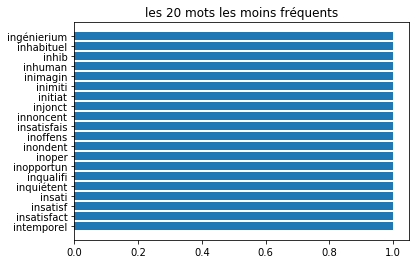

In [121]:
tf = X.toarray().sum(0)
n = 20
ind = tf.argsort()[:n]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

Text(0.5, 1.0, 'les 20 mots les plus fréquents')

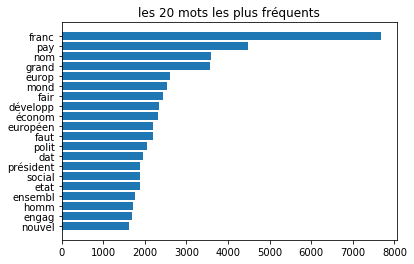

In [122]:
ind = tf.argsort()[-n:]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [123]:
X_test = vectorizer.transform(corpus_test)

#### SVM

In [ ]:
clf_svm = svm.LinearSVC()

# apprentissage
clf_svm.fit(X.toarray(), labels_train)  

In [ ]:
clf_svm.score(X_test, labels_test)

In [ ]:
y_pred = clf_svm.predict(X_test)

In [ ]:
f1_score(labels_test,y_pred)

#### Naive Bayes

In [ ]:
clf_bayes = bayes.MultinomialNB()

clf_bayes.fit(X.toarray(), labels_train) 

In [ ]:
clf_bayes.score(X_test, labels_test)

In [ ]:
y_pred = clf_bayes.predict(X_test)

In [ ]:
f1_score(labels_test,y_pred)

#### Régression Logistique

In [ ]:
clf_reglin = lin.LogisticRegression()

clf_reglin.fit(X.toarray(), labels_train)

In [ ]:
clf_reglin.score(X_test, labels_test)

In [ ]:
f1_score(labels_test,)